# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-04 23:34:54,954 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-04 23:34:54,955 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-04 23:34:55,796 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:08<00:00, 219.30it/s]


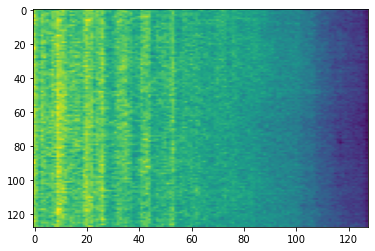

2020-11-04 23:35:21,330 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:54.513495, valid_AUC:0.521445, valid_pAUC:0.499240
100%|██████████| 1803/1803 [00:08<00:00, 220.05it/s]
2020-11-04 23:35:44,874 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:23.571635, valid_AUC:0.553494, valid_pAUC:0.492901
100%|██████████| 1803/1803 [00:08<00:00, 216.28it/s]
2020-11-04 23:36:08,508 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.468763, valid_AUC:0.539989, valid_pAUC:0.500450
100%|██████████| 1803/1803 [00:08<00:00, 219.89it/s]
2020-11-04 23:36:32,001 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.634459, valid_AUC:0.510429, valid_pAUC:0.498284
100%|██████████| 1803/1803 [00:08<00:00, 217.40it/s]
2020-11-04 23:36:55,639 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:14.211476, valid_AUC:0.544803, valid_pAUC:0.500853
100%|██████████| 1803/1803 [00:08<00:00, 217.01it/s]
2020-11-04 23:37:19,233 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:14.093388, valid_A

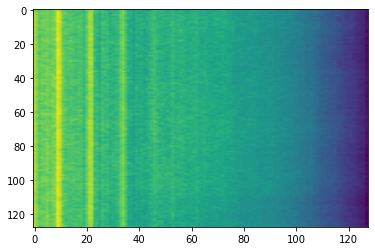

2020-11-04 23:38:54,269 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:12.257168, valid_AUC:0.583836, valid_pAUC:0.500206
100%|██████████| 1803/1803 [00:08<00:00, 218.18it/s]
2020-11-04 23:39:17,799 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:12.172688, valid_AUC:0.586033, valid_pAUC:0.498368
100%|██████████| 1803/1803 [00:08<00:00, 217.95it/s]
2020-11-04 23:39:41,267 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:11.721566, valid_AUC:0.558079, valid_pAUC:0.502363
100%|██████████| 1803/1803 [00:08<00:00, 215.88it/s]
2020-11-04 23:40:04,836 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:11.526723, valid_AUC:0.571262, valid_pAUC:0.503010
100%|██████████| 1803/1803 [00:08<00:00, 217.61it/s]
2020-11-04 23:40:28,413 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:11.424013, valid_AUC:0.569769, valid_pAUC:0.502279
100%|██████████| 1803/1803 [00:08<00:00, 217.03it/s]
2020-11-04 23:40:51,988 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:11.206542, v

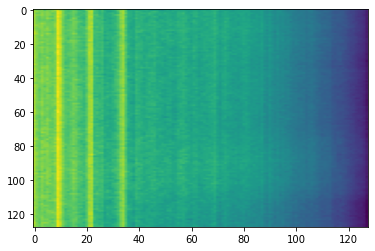

2020-11-04 23:42:47,771 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:11.585343, valid_AUC:0.574305, valid_pAUC:0.504942
100%|██████████| 1803/1803 [00:07<00:00, 226.09it/s]
2020-11-04 23:43:10,434 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:11.005855, valid_AUC:0.592545, valid_pAUC:0.507278
100%|██████████| 1803/1803 [00:07<00:00, 227.05it/s]
2020-11-04 23:43:33,158 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:11.009725, valid_AUC:0.585027, valid_pAUC:0.509613
100%|██████████| 1803/1803 [00:07<00:00, 226.91it/s]
2020-11-04 23:43:55,721 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:10.819438, valid_AUC:0.572512, valid_pAUC:0.508928
100%|██████████| 1803/1803 [00:07<00:00, 226.20it/s]
2020-11-04 23:44:18,690 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:10.831213, valid_AUC:0.576251, valid_pAUC:0.502495
100%|██████████| 1803/1803 [00:07<00:00, 227.09it/s]
2020-11-04 23:44:41,528 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:11.657262, v

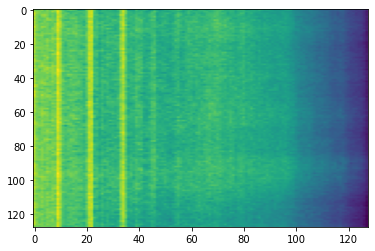

2020-11-04 23:46:34,938 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:10.494754, valid_AUC:0.585064, valid_pAUC:0.506068
100%|██████████| 1803/1803 [00:07<00:00, 227.41it/s]
2020-11-04 23:46:57,604 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:10.707271, valid_AUC:0.569070, valid_pAUC:0.510185
100%|██████████| 1803/1803 [00:07<00:00, 226.91it/s]
2020-11-04 23:47:20,278 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:10.883191, valid_AUC:0.571761, valid_pAUC:0.506706
100%|██████████| 1803/1803 [00:07<00:00, 226.83it/s]
2020-11-04 23:47:43,025 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:10.557545, valid_AUC:0.597587, valid_pAUC:0.510466
100%|██████████| 1803/1803 [00:08<00:00, 224.16it/s]
2020-11-04 23:48:05,868 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:10.457671, valid_AUC:0.594034, valid_pAUC:0.507306
100%|██████████| 1803/1803 [00:07<00:00, 227.32it/s]
2020-11-04 23:48:28,707 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:10.445655, v

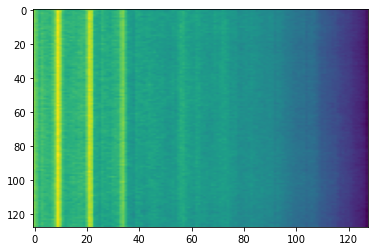

2020-11-04 23:50:21,991 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:10.836733, valid_AUC:0.551648, valid_pAUC:0.505505
100%|██████████| 1803/1803 [00:07<00:00, 226.22it/s]
2020-11-04 23:50:44,743 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:10.908772, valid_AUC:0.592324, valid_pAUC:0.504802
100%|██████████| 1803/1803 [00:07<00:00, 226.86it/s]
2020-11-04 23:51:07,401 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:10.510141, valid_AUC:0.555144, valid_pAUC:0.501660
100%|██████████| 1803/1803 [00:07<00:00, 226.24it/s]
2020-11-04 23:51:30,177 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.658315, valid_AUC:0.582771, valid_pAUC:0.503029
100%|██████████| 1803/1803 [00:07<00:00, 226.67it/s]
2020-11-04 23:51:52,870 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.363016, valid_AUC:0.582870, valid_pAUC:0.504136
100%|██████████| 1803/1803 [00:07<00:00, 226.92it/s]
2020-11-04 23:52:15,587 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.370712, v

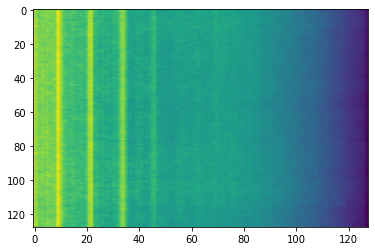

2020-11-04 23:54:08,817 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.518712, valid_AUC:0.574980, valid_pAUC:0.506115
100%|██████████| 1803/1803 [00:07<00:00, 226.39it/s]
2020-11-04 23:54:31,514 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.371294, valid_AUC:0.583216, valid_pAUC:0.504971
100%|██████████| 1803/1803 [00:07<00:00, 227.06it/s]
2020-11-04 23:54:54,134 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.223193, valid_AUC:0.586857, valid_pAUC:0.502523
100%|██████████| 1803/1803 [00:07<00:00, 227.12it/s]
2020-11-04 23:55:16,703 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.219262, valid_AUC:0.589371, valid_pAUC:0.503704
100%|██████████| 1803/1803 [00:07<00:00, 227.13it/s]
2020-11-04 23:55:39,357 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.224471, valid_AUC:0.588181, valid_pAUC:0.509275
100%|██████████| 1803/1803 [00:07<00:00, 226.43it/s]
2020-11-04 23:56:02,088 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.202707, v

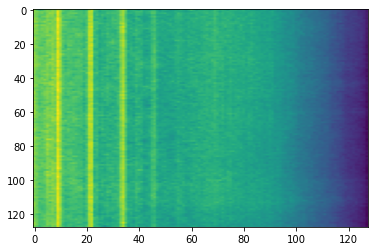

2020-11-04 23:58:01,937 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.075148, valid_AUC:0.592418, valid_pAUC:0.514837
100%|██████████| 1803/1803 [00:08<00:00, 206.80it/s]
2020-11-04 23:58:26,573 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.033744, valid_AUC:0.599517, valid_pAUC:0.517275
100%|██████████| 1803/1803 [00:08<00:00, 212.20it/s]
2020-11-04 23:58:50,659 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.028318, valid_AUC:0.599191, valid_pAUC:0.522611
100%|██████████| 1803/1803 [00:08<00:00, 217.42it/s]
2020-11-04 23:59:14,547 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.081737, valid_AUC:0.596620, valid_pAUC:0.510354
100%|██████████| 1803/1803 [00:08<00:00, 217.23it/s]
2020-11-04 23:59:38,282 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.067068, valid_AUC:0.584502, valid_pAUC:0.521195
100%|██████████| 1803/1803 [00:08<00:00, 218.38it/s]
2020-11-05 00:00:02,055 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.304452, v

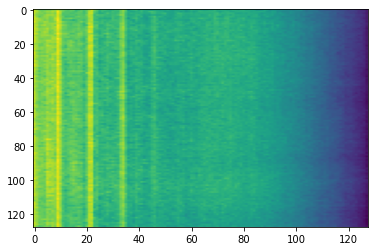

2020-11-05 00:02:00,876 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.081326, valid_AUC:0.583349, valid_pAUC:0.512070
100%|██████████| 1803/1803 [00:08<00:00, 216.89it/s]
2020-11-05 00:02:24,746 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.421175, valid_AUC:0.455112, valid_pAUC:0.498509
100%|██████████| 1803/1803 [00:08<00:00, 213.92it/s]
2020-11-05 00:02:48,863 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.253408, valid_AUC:0.573550, valid_pAUC:0.509688
100%|██████████| 1803/1803 [00:08<00:00, 213.04it/s]
2020-11-05 00:03:13,140 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.727208, valid_AUC:0.556199, valid_pAUC:0.502420
100%|██████████| 1803/1803 [00:08<00:00, 215.43it/s]
2020-11-05 00:03:36,950 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.381971, valid_AUC:0.594692, valid_pAUC:0.507437
100%|██████████| 1803/1803 [00:08<00:00, 210.12it/s]
2020-11-05 00:04:00,930 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.306912, v

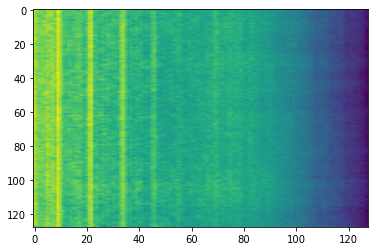

2020-11-05 00:06:02,614 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.081964, valid_AUC:0.621471, valid_pAUC:0.509913
100%|██████████| 1803/1803 [00:08<00:00, 213.76it/s]
2020-11-05 00:06:27,098 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.016148, valid_AUC:0.582563, valid_pAUC:0.505650
100%|██████████| 1803/1803 [00:08<00:00, 212.74it/s]
2020-11-05 00:06:51,095 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.056247, valid_AUC:0.576155, valid_pAUC:0.509514
100%|██████████| 1803/1803 [00:08<00:00, 213.90it/s]
2020-11-05 00:07:15,035 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.054768, valid_AUC:0.588307, valid_pAUC:0.517584
100%|██████████| 1803/1803 [00:08<00:00, 203.99it/s]
2020-11-05 00:07:39,381 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.002158, valid_AUC:0.584323, valid_pAUC:0.511423
100%|██████████| 1803/1803 [00:08<00:00, 207.08it/s]
2020-11-05 00:08:03,918 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.197363, v

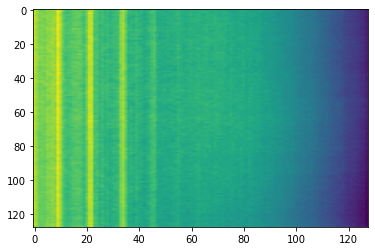

2020-11-05 00:10:31,335 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.185665, valid_AUC:0.591465, valid_pAUC:0.509838
100%|██████████| 1803/1803 [00:15<00:00, 119.18it/s]
2020-11-05 00:11:13,083 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.165340, valid_AUC:0.595805, valid_pAUC:0.510860
100%|██████████| 1803/1803 [00:14<00:00, 120.97it/s]
2020-11-05 00:11:52,794 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.143632, valid_AUC:0.596757, valid_pAUC:0.512858
100%|██████████| 1803/1803 [00:14<00:00, 121.83it/s]
2020-11-05 00:12:33,946 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.006699, valid_AUC:0.594198, valid_pAUC:0.514461
100%|██████████| 1803/1803 [00:15<00:00, 117.30it/s]
2020-11-05 00:13:14,133 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.048297, valid_AUC:0.557744, valid_pAUC:0.503958
100%|██████████| 1803/1803 [00:14<00:00, 124.47it/s]
2020-11-05 00:13:54,669 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.143250, v

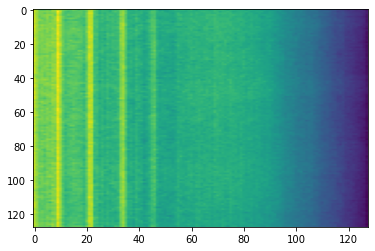

2020-11-05 00:17:17,394 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.337069, valid_AUC:0.575235, valid_pAUC:0.510354
2020-11-05 00:17:18,065 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/fan_model.pth


elapsed time: 2543.111781836 [sec]


2020-11-05 00:17:18,706 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-05 00:17:18,707 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 00:17:18,709 - 00_train.py - INFO - TRAINING
  0%|          | 0/181 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:10<00:00, 77.52it/s]


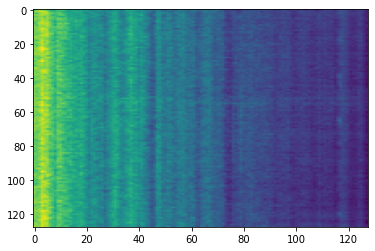

2020-11-05 00:18:48,941 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:64.358220, valid_AUC:0.504844, valid_pAUC:0.482304
100%|██████████| 832/832 [00:07<00:00, 117.90it/s]
2020-11-05 00:19:18,302 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:23.210603, valid_AUC:0.663478, valid_pAUC:0.506944
100%|██████████| 832/832 [00:07<00:00, 117.61it/s]
2020-11-05 00:19:49,434 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:21.020276, valid_AUC:0.588958, valid_pAUC:0.504234
100%|██████████| 832/832 [00:06<00:00, 124.14it/s]
2020-11-05 00:20:18,398 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.713307, valid_AUC:0.699138, valid_pAUC:0.568683
100%|██████████| 832/832 [00:07<00:00, 118.25it/s]
2020-11-05 00:20:49,113 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.924257, valid_AUC:0.661829, valid_pAUC:0.562865
100%|██████████| 832/832 [00:06<00:00, 122.86it/s]
2020-11-05 00:21:18,774 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.554605, valid_AUC:0.68463

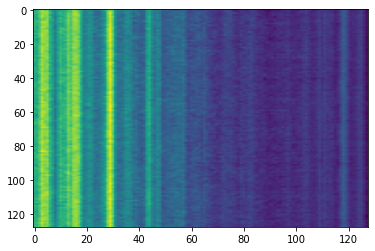

2020-11-05 00:23:20,135 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:13.464212, valid_AUC:0.657784, valid_pAUC:0.571333
100%|██████████| 832/832 [00:06<00:00, 123.44it/s]
2020-11-05 00:23:49,257 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:13.180151, valid_AUC:0.703675, valid_pAUC:0.596948
100%|██████████| 832/832 [00:06<00:00, 119.07it/s]
2020-11-05 00:24:19,947 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:12.924604, valid_AUC:0.710069, valid_pAUC:0.603222
100%|██████████| 832/832 [00:06<00:00, 124.08it/s]
2020-11-05 00:24:49,173 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:12.874329, valid_AUC:0.706557, valid_pAUC:0.600634
100%|██████████| 832/832 [00:06<00:00, 118.91it/s]
2020-11-05 00:25:18,616 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:12.572199, valid_AUC:0.735023, valid_pAUC:0.621924
100%|██████████| 832/832 [00:06<00:00, 123.77it/s]
2020-11-05 00:25:48,320 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:12.710149, valid_AUC:0

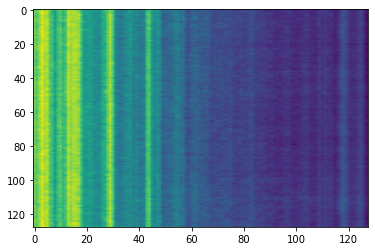

2020-11-05 00:28:12,154 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.630701, valid_AUC:0.668900, valid_pAUC:0.591100
100%|██████████| 832/832 [00:06<00:00, 124.08it/s]
2020-11-05 00:28:40,767 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:12.424845, valid_AUC:0.674109, valid_pAUC:0.573038
100%|██████████| 832/832 [00:06<00:00, 125.08it/s]
2020-11-05 00:29:09,261 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:12.400245, valid_AUC:0.694902, valid_pAUC:0.604349
100%|██████████| 832/832 [00:06<00:00, 124.16it/s]
2020-11-05 00:29:37,907 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:11.739644, valid_AUC:0.655579, valid_pAUC:0.549799
100%|██████████| 832/832 [00:06<00:00, 120.28it/s]
2020-11-05 00:30:06,760 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:11.847888, valid_AUC:0.706111, valid_pAUC:0.621954
100%|██████████| 832/832 [00:06<00:00, 125.75it/s]
2020-11-05 00:30:35,529 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:11.528129, valid_AUC:0

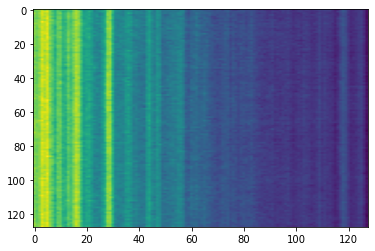

2020-11-05 00:32:57,603 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.300471, valid_AUC:0.709948, valid_pAUC:0.633071
100%|██████████| 832/832 [00:06<00:00, 124.56it/s]
2020-11-05 00:33:25,858 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.170792, valid_AUC:0.698530, valid_pAUC:0.624330
100%|██████████| 832/832 [00:06<00:00, 126.72it/s]
2020-11-05 00:33:54,250 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.323964, valid_AUC:0.723267, valid_pAUC:0.645102
100%|██████████| 832/832 [00:06<00:00, 124.21it/s]
2020-11-05 00:34:22,670 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:10.956738, valid_AUC:0.705642, valid_pAUC:0.625975
100%|██████████| 832/832 [00:06<00:00, 127.04it/s]
2020-11-05 00:34:50,946 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:10.990070, valid_AUC:0.696516, valid_pAUC:0.626371
100%|██████████| 832/832 [00:06<00:00, 124.26it/s]
2020-11-05 00:35:19,358 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.162268, valid_AUC:0

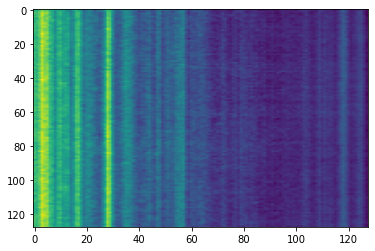

2020-11-05 00:37:42,102 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:10.863590, valid_AUC:0.689462, valid_pAUC:0.602857
100%|██████████| 832/832 [00:06<00:00, 123.23it/s]
2020-11-05 00:38:10,855 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:10.957763, valid_AUC:0.713999, valid_pAUC:0.656220
100%|██████████| 832/832 [00:06<00:00, 126.48it/s]
2020-11-05 00:38:39,210 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.027081, valid_AUC:0.708675, valid_pAUC:0.662311
100%|██████████| 832/832 [00:06<00:00, 123.16it/s]
2020-11-05 00:39:07,661 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.821594, valid_AUC:0.718964, valid_pAUC:0.661885
100%|██████████| 832/832 [00:06<00:00, 128.44it/s]
2020-11-05 00:39:35,962 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.887888, valid_AUC:0.694716, valid_pAUC:0.599507
100%|██████████| 832/832 [00:06<00:00, 121.00it/s]
2020-11-05 00:40:04,652 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.765190, valid_AUC:0

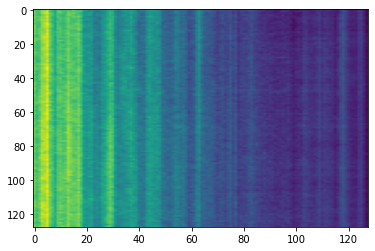

2020-11-05 00:42:26,802 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.987177, valid_AUC:0.692014, valid_pAUC:0.624970
100%|██████████| 832/832 [00:06<00:00, 128.28it/s]
2020-11-05 00:42:55,037 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.090749, valid_AUC:0.562662, valid_pAUC:0.504751
100%|██████████| 832/832 [00:06<00:00, 124.78it/s]
2020-11-05 00:43:23,385 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.953065, valid_AUC:0.714016, valid_pAUC:0.655154
100%|██████████| 832/832 [00:06<00:00, 126.58it/s]
2020-11-05 00:43:51,689 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.006451, valid_AUC:0.728131, valid_pAUC:0.639224
100%|██████████| 832/832 [00:06<00:00, 126.67it/s]
2020-11-05 00:44:20,028 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.051993, valid_AUC:0.685133, valid_pAUC:0.579435
100%|██████████| 832/832 [00:06<00:00, 123.07it/s]
2020-11-05 00:44:48,890 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.910446, valid_AUC:0

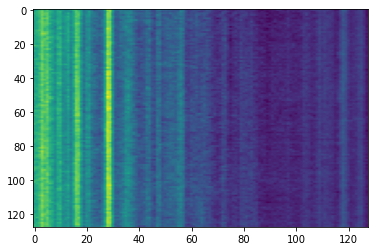

2020-11-05 00:47:11,173 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.501853, valid_AUC:0.717355, valid_pAUC:0.640046
100%|██████████| 832/832 [00:06<00:00, 126.22it/s]
2020-11-05 00:47:39,714 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.566813, valid_AUC:0.739780, valid_pAUC:0.668037
100%|██████████| 832/832 [00:06<00:00, 121.98it/s]
2020-11-05 00:48:08,431 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.200532, valid_AUC:0.706591, valid_pAUC:0.613791
100%|██████████| 832/832 [00:06<00:00, 127.69it/s]
2020-11-05 00:48:36,662 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.797248, valid_AUC:0.731128, valid_pAUC:0.646778
100%|██████████| 832/832 [00:06<00:00, 122.81it/s]
2020-11-05 00:49:05,215 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.548798, valid_AUC:0.715197, valid_pAUC:0.608766
100%|██████████| 832/832 [00:06<00:00, 128.49it/s]
2020-11-05 00:49:33,575 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.719777, valid_AUC:0

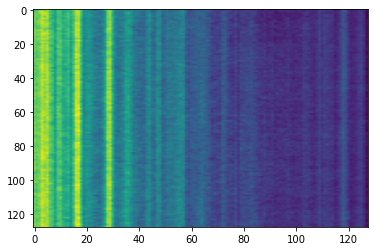

2020-11-05 00:51:56,043 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.976614, valid_AUC:0.713941, valid_pAUC:0.642879
100%|██████████| 832/832 [00:06<00:00, 123.88it/s]
2020-11-05 00:52:24,761 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.841735, valid_AUC:0.700851, valid_pAUC:0.636574
100%|██████████| 832/832 [00:06<00:00, 128.11it/s]
2020-11-05 00:52:53,143 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.746001, valid_AUC:0.714375, valid_pAUC:0.647052
100%|██████████| 832/832 [00:06<00:00, 124.34it/s]
2020-11-05 00:53:21,588 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.607783, valid_AUC:0.709091, valid_pAUC:0.633102
100%|██████████| 832/832 [00:06<00:00, 121.82it/s]
2020-11-05 00:53:50,261 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.760993, valid_AUC:0.708964, valid_pAUC:0.658808
100%|██████████| 832/832 [00:06<00:00, 127.91it/s]
2020-11-05 00:54:18,707 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.546417, valid_AUC:0

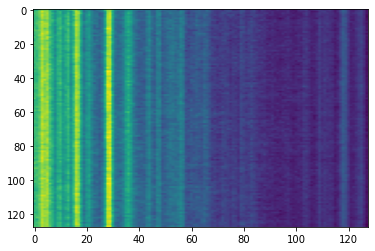

2020-11-05 00:56:40,875 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.440337, valid_AUC:0.678848, valid_pAUC:0.609405
100%|██████████| 832/832 [00:06<00:00, 123.88it/s]
2020-11-05 00:57:09,547 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.596191, valid_AUC:0.711001, valid_pAUC:0.667337
100%|██████████| 832/832 [00:06<00:00, 127.97it/s]
2020-11-05 00:57:37,965 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.446259, valid_AUC:0.690243, valid_pAUC:0.568683
100%|██████████| 832/832 [00:06<00:00, 121.64it/s]
2020-11-05 00:58:06,807 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.129481, valid_AUC:0.684497, valid_pAUC:0.566185
100%|██████████| 832/832 [00:06<00:00, 128.05it/s]
2020-11-05 00:58:35,084 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.846010, valid_AUC:0.680584, valid_pAUC:0.546753
100%|██████████| 832/832 [00:06<00:00, 123.12it/s]
2020-11-05 00:59:03,790 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.656124, valid_AUC:0

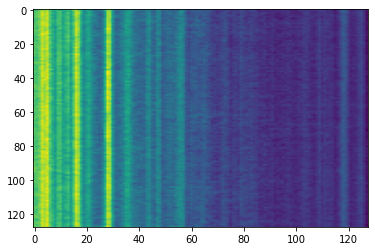

2020-11-05 01:01:26,610 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.297058, valid_AUC:0.679010, valid_pAUC:0.557627
100%|██████████| 832/832 [00:06<00:00, 128.35it/s]
2020-11-05 01:01:54,866 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.430914, valid_AUC:0.691146, valid_pAUC:0.569688
100%|██████████| 832/832 [00:06<00:00, 125.38it/s]
2020-11-05 01:02:23,272 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.409674, valid_AUC:0.698785, valid_pAUC:0.583364
100%|██████████| 832/832 [00:06<00:00, 124.54it/s]
2020-11-05 01:02:51,777 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.351815, valid_AUC:0.684248, valid_pAUC:0.559028
100%|██████████| 832/832 [00:06<00:00, 127.61it/s]
2020-11-05 01:03:20,250 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.266813, valid_AUC:0.694034, valid_pAUC:0.593110
100%|██████████| 832/832 [00:06<00:00, 120.39it/s]
2020-11-05 01:03:48,836 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.282586, valid_AUC:0

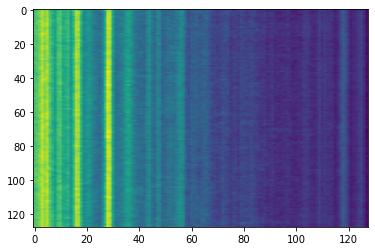

2020-11-05 01:06:16,730 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.360148, valid_AUC:0.710509, valid_pAUC:0.602613
2020-11-05 01:06:17,563 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/pump_model.pth


elapsed time: 2938.858366966 [sec]


2020-11-05 01:06:18,387 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-05 01:06:18,388 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 01:06:18,390 - 00_train.py - INFO - TRAINING
  0%|          | 0/162 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:17<00:00, 72.98it/s]


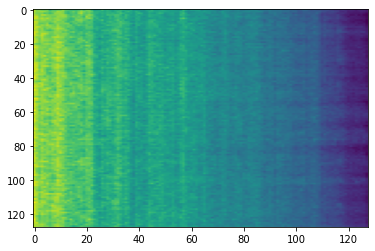

2020-11-05 01:07:46,003 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:71.200212, valid_AUC:0.612394, valid_pAUC:0.499316
100%|██████████| 1246/1246 [00:10<00:00, 121.97it/s]
2020-11-05 01:08:16,452 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:27.834289, valid_AUC:0.646312, valid_pAUC:0.521308
100%|██████████| 1246/1246 [00:10<00:00, 119.69it/s]
2020-11-05 01:08:47,709 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:23.423495, valid_AUC:0.567261, valid_pAUC:0.495490
100%|██████████| 1246/1246 [00:10<00:00, 124.30it/s]
2020-11-05 01:09:17,850 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:21.879002, valid_AUC:0.758774, valid_pAUC:0.564841
100%|██████████| 1246/1246 [00:10<00:00, 118.90it/s]
2020-11-05 01:09:48,795 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:18.954887, valid_AUC:0.696752, valid_pAUC:0.524978
100%|██████████| 1246/1246 [00:10<00:00, 123.77it/s]
2020-11-05 01:10:19,458 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:18.271697, valid_A

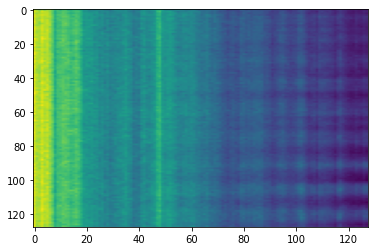

2020-11-05 01:12:24,148 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.927956, valid_AUC:0.729823, valid_pAUC:0.539023
100%|██████████| 1246/1246 [00:10<00:00, 124.51it/s]
2020-11-05 01:12:54,331 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.752471, valid_AUC:0.720322, valid_pAUC:0.537561
100%|██████████| 1246/1246 [00:10<00:00, 119.83it/s]
2020-11-05 01:13:25,445 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.274646, valid_AUC:0.725700, valid_pAUC:0.541651
100%|██████████| 1246/1246 [00:10<00:00, 121.61it/s]
2020-11-05 01:13:56,419 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:14.846135, valid_AUC:0.738215, valid_pAUC:0.548603
100%|██████████| 1246/1246 [00:10<00:00, 114.90it/s]
2020-11-05 01:14:27,840 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:14.682977, valid_AUC:0.742686, valid_pAUC:0.548634
100%|██████████| 1246/1246 [00:10<00:00, 121.99it/s]
2020-11-05 01:14:57,741 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:14.046707, v

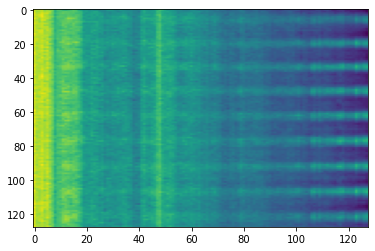

2020-11-05 01:17:33,463 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.100272, valid_AUC:0.777751, valid_pAUC:0.602619
100%|██████████| 1246/1246 [00:10<00:00, 114.17it/s]
2020-11-05 01:18:05,018 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:12.818503, valid_AUC:0.777902, valid_pAUC:0.620054
100%|██████████| 1246/1246 [00:09<00:00, 126.20it/s]
2020-11-05 01:18:35,419 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:12.559208, valid_AUC:0.775124, valid_pAUC:0.609089
100%|██████████| 1246/1246 [00:10<00:00, 121.43it/s]
2020-11-05 01:19:05,747 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:12.435969, valid_AUC:0.784140, valid_pAUC:0.619867
100%|██████████| 1246/1246 [00:09<00:00, 125.21it/s]
2020-11-05 01:19:36,310 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.407110, valid_AUC:0.792686, valid_pAUC:0.633554
100%|██████████| 1246/1246 [00:10<00:00, 117.20it/s]
2020-11-05 01:20:07,093 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.495620, v

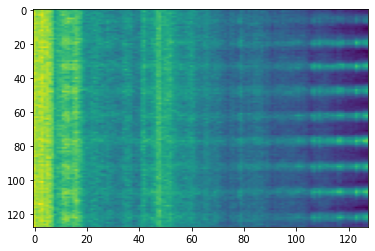

2020-11-05 01:22:40,119 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.743560, valid_AUC:0.772775, valid_pAUC:0.614859
100%|██████████| 1246/1246 [00:09<00:00, 127.24it/s]
2020-11-05 01:23:09,957 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.675784, valid_AUC:0.788573, valid_pAUC:0.621407
100%|██████████| 1246/1246 [00:10<00:00, 121.66it/s]
2020-11-05 01:23:40,200 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.944358, valid_AUC:0.783395, valid_pAUC:0.614642
100%|██████████| 1246/1246 [00:09<00:00, 124.98it/s]
2020-11-05 01:24:10,341 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.612027, valid_AUC:0.781741, valid_pAUC:0.603397
100%|██████████| 1246/1246 [00:10<00:00, 122.41it/s]
2020-11-05 01:24:40,433 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.489797, valid_AUC:0.783389, valid_pAUC:0.622963
100%|██████████| 1246/1246 [00:10<00:00, 124.36it/s]
2020-11-05 01:25:10,706 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.514773, v

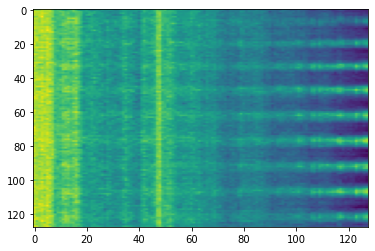

2020-11-05 01:27:40,232 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.298682, valid_AUC:0.783611, valid_pAUC:0.617923
100%|██████████| 1246/1246 [00:10<00:00, 122.45it/s]
2020-11-05 01:28:09,944 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.222940, valid_AUC:0.785095, valid_pAUC:0.615217
100%|██████████| 1246/1246 [00:09<00:00, 128.20it/s]
2020-11-05 01:28:39,077 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.260991, valid_AUC:0.787414, valid_pAUC:0.608203
100%|██████████| 1246/1246 [00:10<00:00, 123.87it/s]
2020-11-05 01:29:08,720 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.150673, valid_AUC:0.786611, valid_pAUC:0.612013
100%|██████████| 1246/1246 [00:10<00:00, 123.03it/s]
2020-11-05 01:29:38,546 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.003391, valid_AUC:0.781312, valid_pAUC:0.608638
100%|██████████| 1246/1246 [00:09<00:00, 126.77it/s]
2020-11-05 01:30:07,843 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.972324, v

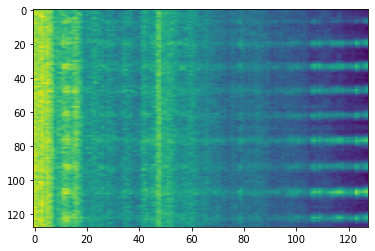

2020-11-05 01:32:35,185 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.844391, valid_AUC:0.782453, valid_pAUC:0.607596
100%|██████████| 1246/1246 [00:09<00:00, 125.15it/s]
2020-11-05 01:33:04,695 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.064055, valid_AUC:0.305860, valid_pAUC:0.486749
100%|██████████| 1246/1246 [00:09<00:00, 127.24it/s]
2020-11-05 01:33:34,036 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.513171, valid_AUC:0.725957, valid_pAUC:0.529846
100%|██████████| 1246/1246 [00:10<00:00, 123.00it/s]
2020-11-05 01:34:03,817 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.132677, valid_AUC:0.530106, valid_pAUC:0.512256
100%|██████████| 1246/1246 [00:09<00:00, 128.02it/s]
2020-11-05 01:34:33,198 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.664157, valid_AUC:0.777228, valid_pAUC:0.609727
100%|██████████| 1246/1246 [00:10<00:00, 123.32it/s]
2020-11-05 01:35:02,849 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.875511, v

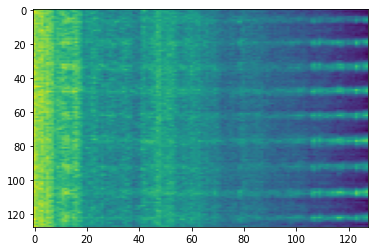

2020-11-05 01:37:30,685 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.867067, valid_AUC:0.778307, valid_pAUC:0.624518
100%|██████████| 1246/1246 [00:09<00:00, 128.30it/s]
2020-11-05 01:38:00,118 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.324419, valid_AUC:0.764941, valid_pAUC:0.580627
100%|██████████| 1246/1246 [00:10<00:00, 124.07it/s]
2020-11-05 01:38:29,737 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.481399, valid_AUC:0.741912, valid_pAUC:0.522925
100%|██████████| 1246/1246 [00:09<00:00, 128.21it/s]
2020-11-05 01:38:59,067 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.592953, valid_AUC:0.767012, valid_pAUC:0.589399
100%|██████████| 1246/1246 [00:10<00:00, 124.02it/s]
2020-11-05 01:39:28,641 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.228756, valid_AUC:0.761717, valid_pAUC:0.559055
100%|██████████| 1246/1246 [00:09<00:00, 127.19it/s]
2020-11-05 01:39:58,296 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.931130, v

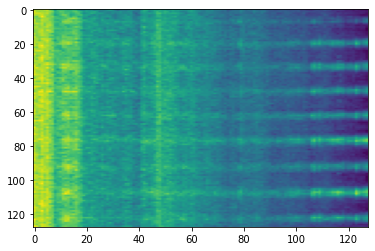

2020-11-05 01:42:26,068 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.916284, valid_AUC:0.784436, valid_pAUC:0.602666
100%|██████████| 1246/1246 [00:10<00:00, 123.66it/s]
2020-11-05 01:42:55,588 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.845051, valid_AUC:0.614462, valid_pAUC:0.591390
100%|██████████| 1246/1246 [00:09<00:00, 128.51it/s]
2020-11-05 01:43:24,989 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:12.044639, valid_AUC:0.753596, valid_pAUC:0.514962
100%|██████████| 1246/1246 [00:10<00:00, 122.23it/s]
2020-11-05 01:43:54,737 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.263893, valid_AUC:0.762852, valid_pAUC:0.551978
100%|██████████| 1246/1246 [00:09<00:00, 125.10it/s]
2020-11-05 01:44:24,591 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.953873, valid_AUC:0.777946, valid_pAUC:0.563145
100%|██████████| 1246/1246 [00:09<00:00, 126.58it/s]
2020-11-05 01:44:53,981 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.699550, v

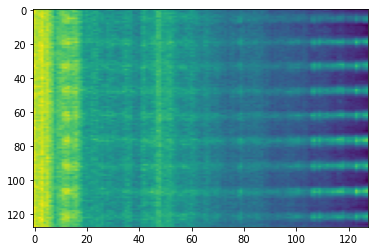

2020-11-05 01:47:21,203 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.482862, valid_AUC:0.744285, valid_pAUC:0.515895
100%|██████████| 1246/1246 [00:09<00:00, 125.98it/s]
2020-11-05 01:47:50,678 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.442621, valid_AUC:0.769090, valid_pAUC:0.557018
100%|██████████| 1246/1246 [00:09<00:00, 125.63it/s]
2020-11-05 01:48:20,296 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.459541, valid_AUC:0.779119, valid_pAUC:0.590083
100%|██████████| 1246/1246 [00:10<00:00, 124.26it/s]
2020-11-05 01:48:50,183 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.470856, valid_AUC:0.776968, valid_pAUC:0.589523
100%|██████████| 1246/1246 [00:09<00:00, 128.09it/s]
2020-11-05 01:49:19,531 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.506766, valid_AUC:0.764962, valid_pAUC:0.559957
100%|██████████| 1246/1246 [00:10<00:00, 122.50it/s]
2020-11-05 01:49:49,243 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.704708, v

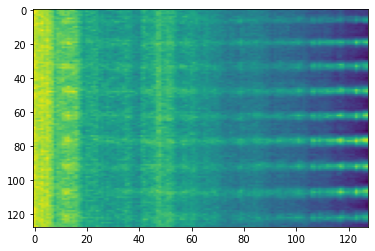

2020-11-05 01:52:16,804 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.688784, valid_AUC:0.757311, valid_pAUC:0.544311
100%|██████████| 1246/1246 [00:09<00:00, 129.88it/s]
2020-11-05 01:52:45,892 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.591322, valid_AUC:0.772332, valid_pAUC:0.586242
100%|██████████| 1246/1246 [00:09<00:00, 124.83it/s]
2020-11-05 01:53:15,267 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.805478, valid_AUC:0.684187, valid_pAUC:0.507730
100%|██████████| 1246/1246 [00:09<00:00, 128.54it/s]
2020-11-05 01:53:44,571 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:12.369148, valid_AUC:0.750408, valid_pAUC:0.546830
100%|██████████| 1246/1246 [00:10<00:00, 123.59it/s]
2020-11-05 01:54:14,416 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.348976, valid_AUC:0.724770, valid_pAUC:0.512116
100%|██████████| 1246/1246 [00:09<00:00, 128.01it/s]
2020-11-05 01:54:43,929 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.980855, v

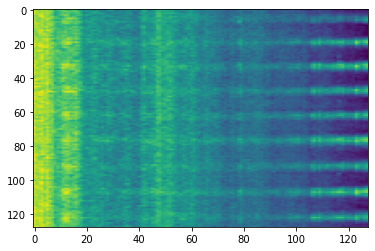

2020-11-05 01:57:11,431 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.559534, valid_AUC:0.781217, valid_pAUC:0.603661
2020-11-05 01:57:12,070 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/slider_model.pth


elapsed time: 3053.684826612 [sec]


2020-11-05 01:57:12,669 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-05 01:57:12,670 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 01:57:12,672 - 00_train.py - INFO - TRAINING
  0%|          | 1/219 [00:00<00:25,  8.62it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:19<00:00, 124.37it/s]


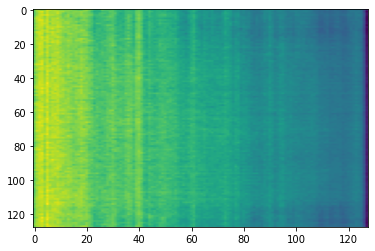

2020-11-05 01:57:59,430 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:51.033490, valid_AUC:0.586863, valid_pAUC:0.504629
100%|██████████| 2407/2407 [00:19<00:00, 124.35it/s]
2020-11-05 01:58:45,629 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:20.563473, valid_AUC:0.623708, valid_pAUC:0.533846
100%|██████████| 2407/2407 [00:18<00:00, 128.24it/s]
2020-11-05 01:59:31,363 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:18.998213, valid_AUC:0.608182, valid_pAUC:0.527451
100%|██████████| 2407/2407 [00:19<00:00, 123.65it/s]
2020-11-05 02:00:17,554 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.880714, valid_AUC:0.650897, valid_pAUC:0.528059
100%|██████████| 2407/2407 [00:19<00:00, 123.37it/s]
2020-11-05 02:01:03,711 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.547890, valid_AUC:0.609932, valid_pAUC:0.528925
100%|██████████| 2407/2407 [00:18<00:00, 127.25it/s]
2020-11-05 02:01:49,576 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:15.061646, valid_A

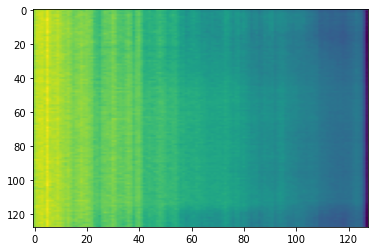

2020-11-05 02:04:52,100 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:13.368554, valid_AUC:0.647789, valid_pAUC:0.513895
100%|██████████| 2407/2407 [00:19<00:00, 125.54it/s]
2020-11-05 02:05:37,631 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:13.365947, valid_AUC:0.614693, valid_pAUC:0.519693
100%|██████████| 2407/2407 [00:19<00:00, 125.48it/s]
2020-11-05 02:06:23,746 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:13.365760, valid_AUC:0.644013, valid_pAUC:0.555316
100%|██████████| 2407/2407 [00:19<00:00, 125.57it/s]
2020-11-05 02:07:09,577 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:12.871576, valid_AUC:0.655549, valid_pAUC:0.553057
100%|██████████| 2407/2407 [00:19<00:00, 124.96it/s]
2020-11-05 02:07:55,546 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:12.470628, valid_AUC:0.661529, valid_pAUC:0.553225
100%|██████████| 2407/2407 [00:19<00:00, 125.39it/s]
2020-11-05 02:08:41,520 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:12.081811, v

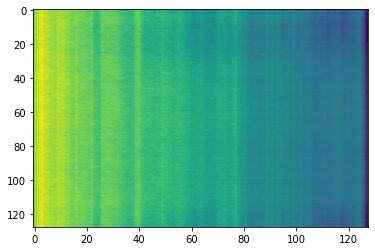

2020-11-05 02:12:32,412 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:11.614479, valid_AUC:0.638752, valid_pAUC:0.532091
100%|██████████| 2407/2407 [00:19<00:00, 123.86it/s]
2020-11-05 02:13:18,606 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:11.237313, valid_AUC:0.647228, valid_pAUC:0.529735
100%|██████████| 2407/2407 [00:19<00:00, 121.61it/s]
2020-11-05 02:14:05,180 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:11.053573, valid_AUC:0.645938, valid_pAUC:0.527861
100%|██████████| 2407/2407 [00:19<00:00, 124.34it/s]
2020-11-05 02:14:51,247 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:10.797067, valid_AUC:0.654658, valid_pAUC:0.540159
100%|██████████| 2407/2407 [00:19<00:00, 125.06it/s]
2020-11-05 02:15:37,217 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:10.579303, valid_AUC:0.632238, valid_pAUC:0.535089
100%|██████████| 2407/2407 [00:19<00:00, 123.53it/s]
2020-11-05 02:16:23,625 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:10.326763, v

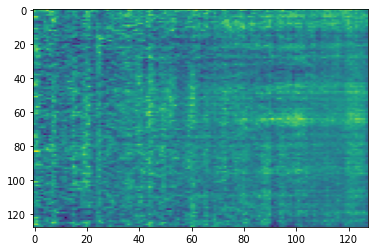

2020-11-05 02:20:15,431 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:10.167277, valid_AUC:0.675095, valid_pAUC:0.559975
100%|██████████| 2407/2407 [00:19<00:00, 124.53it/s]
2020-11-05 02:21:01,550 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:10.074422, valid_AUC:0.647751, valid_pAUC:0.537146
100%|██████████| 2407/2407 [00:19<00:00, 124.83it/s]
2020-11-05 02:21:47,429 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:9.851581, valid_AUC:0.650256, valid_pAUC:0.537755
100%|██████████| 2407/2407 [00:19<00:00, 125.81it/s]
2020-11-05 02:22:33,641 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:9.619831, valid_AUC:0.651778, valid_pAUC:0.539427
100%|██████████| 2407/2407 [00:19<00:00, 126.03it/s]
2020-11-05 02:23:19,461 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:9.541581, valid_AUC:0.667742, valid_pAUC:0.556346
100%|██████████| 2407/2407 [00:19<00:00, 123.24it/s]
2020-11-05 02:24:05,719 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:9.537679, valid

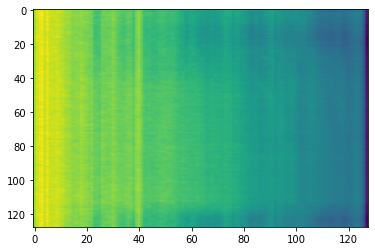

2020-11-05 02:27:54,619 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:9.463269, valid_AUC:0.652211, valid_pAUC:0.515945
100%|██████████| 2407/2407 [00:19<00:00, 126.63it/s]
2020-11-05 02:28:40,587 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:9.443524, valid_AUC:0.664702, valid_pAUC:0.507000
100%|██████████| 2407/2407 [00:18<00:00, 126.69it/s]
2020-11-05 02:29:26,369 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:9.782477, valid_AUC:0.502772, valid_pAUC:0.490555
100%|██████████| 2407/2407 [00:19<00:00, 124.84it/s]
2020-11-05 02:30:12,339 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:9.782368, valid_AUC:0.658467, valid_pAUC:0.517755
100%|██████████| 2407/2407 [00:19<00:00, 126.32it/s]
2020-11-05 02:30:58,176 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:9.369261, valid_AUC:0.655370, valid_pAUC:0.536467
100%|██████████| 2407/2407 [00:19<00:00, 124.87it/s]
2020-11-05 02:31:44,148 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:9.518259, valid_A

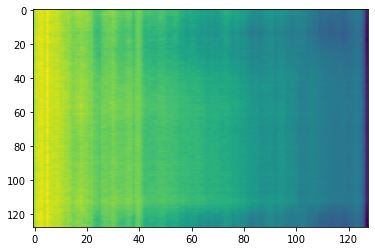

2020-11-05 02:35:35,277 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:9.987843, valid_AUC:0.671452, valid_pAUC:0.556701
100%|██████████| 2407/2407 [00:19<00:00, 122.84it/s]
2020-11-05 02:36:21,461 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:9.851294, valid_AUC:0.397879, valid_pAUC:0.493075
100%|██████████| 2407/2407 [00:19<00:00, 122.51it/s]
2020-11-05 02:37:07,778 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:9.913383, valid_AUC:0.682146, valid_pAUC:0.571492
100%|██████████| 2407/2407 [00:19<00:00, 123.56it/s]
2020-11-05 02:37:53,936 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:9.673805, valid_AUC:0.667428, valid_pAUC:0.544822
100%|██████████| 2407/2407 [00:19<00:00, 123.95it/s]
2020-11-05 02:38:40,086 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.375660, valid_AUC:0.668917, valid_pAUC:0.537437
100%|██████████| 2407/2407 [00:19<00:00, 124.16it/s]
2020-11-05 02:39:26,072 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:9.274419, valid_A

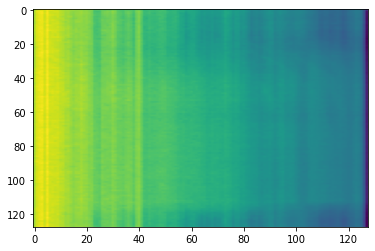

2020-11-05 02:43:17,798 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.556755, valid_AUC:0.651116, valid_pAUC:0.554939
100%|██████████| 2407/2407 [00:19<00:00, 122.82it/s]
2020-11-05 02:44:04,215 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:9.675817, valid_AUC:0.678022, valid_pAUC:0.549417
100%|██████████| 2407/2407 [00:19<00:00, 123.72it/s]
2020-11-05 02:44:50,367 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:9.234245, valid_AUC:0.674380, valid_pAUC:0.541536
100%|██████████| 2407/2407 [00:19<00:00, 123.32it/s]
2020-11-05 02:45:36,666 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:9.074131, valid_AUC:0.687619, valid_pAUC:0.572575
100%|██████████| 2407/2407 [00:19<00:00, 122.97it/s]
2020-11-05 02:46:22,867 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:9.044375, valid_AUC:0.680196, valid_pAUC:0.574706
100%|██████████| 2407/2407 [00:19<00:00, 125.43it/s]
2020-11-05 02:47:09,000 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:9.057032, valid_A

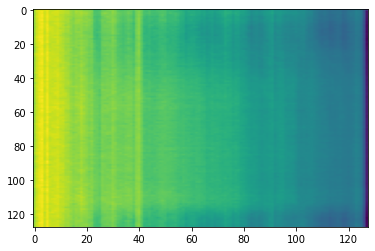

2020-11-05 02:50:58,485 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:9.191189, valid_AUC:0.686667, valid_pAUC:0.558989
100%|██████████| 2407/2407 [00:18<00:00, 126.93it/s]
2020-11-05 02:51:44,172 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:9.596536, valid_AUC:0.675098, valid_pAUC:0.555540
100%|██████████| 2407/2407 [00:19<00:00, 125.58it/s]
2020-11-05 02:52:30,342 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:9.579949, valid_AUC:0.678044, valid_pAUC:0.562360
100%|██████████| 2407/2407 [00:19<00:00, 126.34it/s]
2020-11-05 02:53:16,247 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:9.117517, valid_AUC:0.688810, valid_pAUC:0.557209
100%|██████████| 2407/2407 [00:19<00:00, 125.10it/s]
2020-11-05 02:54:02,120 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:9.011029, valid_AUC:0.676570, valid_pAUC:0.541607
100%|██████████| 2407/2407 [00:19<00:00, 126.07it/s]
2020-11-05 02:54:48,158 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:8.937261, valid_A

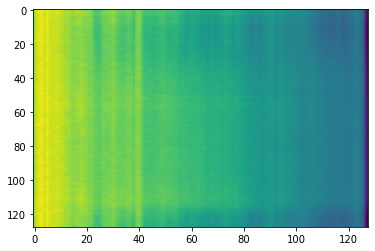

2020-11-05 02:58:38,854 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:8.953613, valid_AUC:0.685215, valid_pAUC:0.562013
100%|██████████| 2407/2407 [00:19<00:00, 125.74it/s]
2020-11-05 02:59:24,806 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:8.856470, valid_AUC:0.666522, valid_pAUC:0.530430
100%|██████████| 2407/2407 [00:19<00:00, 124.18it/s]
2020-11-05 03:00:11,084 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.854451, valid_AUC:0.654032, valid_pAUC:0.512432
100%|██████████| 2407/2407 [00:19<00:00, 123.88it/s]
2020-11-05 03:00:57,339 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.790096, valid_AUC:0.673738, valid_pAUC:0.545938
100%|██████████| 2407/2407 [00:19<00:00, 124.68it/s]
2020-11-05 03:01:43,439 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.242430, valid_AUC:0.673233, valid_pAUC:0.550563
100%|██████████| 2407/2407 [00:19<00:00, 124.10it/s]
2020-11-05 03:02:30,123 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.047538, valid_

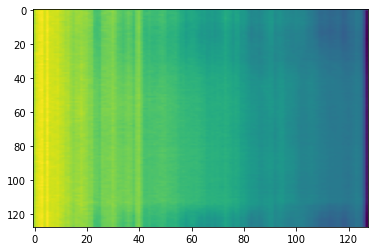

2020-11-05 03:06:21,630 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:8.936135, valid_AUC:0.680129, valid_pAUC:0.554991
100%|██████████| 2407/2407 [00:19<00:00, 122.64it/s]
2020-11-05 03:07:08,034 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.011020, valid_AUC:0.562117, valid_pAUC:0.517236
100%|██████████| 2407/2407 [00:19<00:00, 123.44it/s]
2020-11-05 03:07:54,200 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.323692, valid_AUC:0.670887, valid_pAUC:0.563014
100%|██████████| 2407/2407 [00:19<00:00, 123.70it/s]
2020-11-05 03:08:40,764 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.602052, valid_AUC:0.664828, valid_pAUC:0.546886
100%|██████████| 2407/2407 [00:19<00:00, 123.12it/s]
2020-11-05 03:09:26,863 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.365814, valid_AUC:0.662753, valid_pAUC:0.545079
100%|██████████| 2407/2407 [00:19<00:00, 121.67it/s]
2020-11-05 03:10:13,581 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.141252, valid

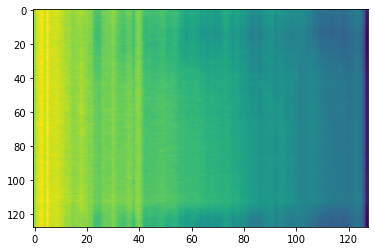

2020-11-05 03:14:05,238 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:8.931132, valid_AUC:0.674338, valid_pAUC:0.536291
2020-11-05 03:14:05,964 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/ToyCar_model.pth


elapsed time: 4613.295956373 [sec]


2020-11-05 03:14:06,729 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-05 03:14:06,729 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 03:14:06,733 - 00_train.py - INFO - TRAINING
  0%|          | 0/188 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:44<00:00, 77.62it/s]


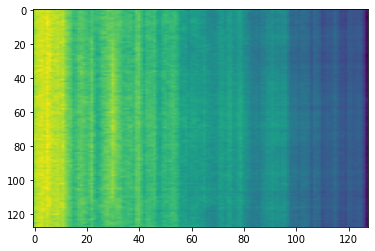

2020-11-05 03:16:13,628 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:44.207824, valid_AUC:0.545122, valid_pAUC:0.508878
100%|██████████| 3452/3452 [00:27<00:00, 124.19it/s]
2020-11-05 03:17:04,092 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:21.658401, valid_AUC:0.569392, valid_pAUC:0.504491
100%|██████████| 3452/3452 [00:28<00:00, 122.46it/s]
2020-11-05 03:17:55,044 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.356414, valid_AUC:0.509797, valid_pAUC:0.510451
100%|██████████| 3452/3452 [00:27<00:00, 123.52it/s]
2020-11-05 03:18:45,887 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:18.682283, valid_AUC:0.571177, valid_pAUC:0.511136
100%|██████████| 3452/3452 [00:28<00:00, 122.89it/s]
2020-11-05 03:19:36,604 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.956650, valid_AUC:0.537328, valid_pAUC:0.505259
100%|██████████| 3452/3452 [00:28<00:00, 123.11it/s]
2020-11-05 03:20:27,347 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:16.351315, valid_A

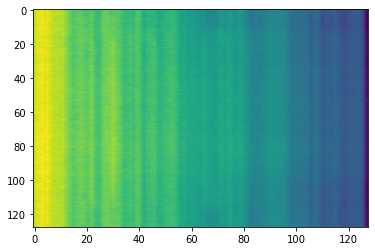

2020-11-05 03:23:49,620 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.084022, valid_AUC:0.559530, valid_pAUC:0.499332
100%|██████████| 3452/3452 [00:27<00:00, 123.90it/s]
2020-11-05 03:24:40,967 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.781410, valid_AUC:0.563869, valid_pAUC:0.500500
100%|██████████| 3452/3452 [00:27<00:00, 123.46it/s]
2020-11-05 03:25:31,479 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:14.825889, valid_AUC:0.576514, valid_pAUC:0.505834
100%|██████████| 3452/3452 [00:28<00:00, 122.41it/s]
2020-11-05 03:26:22,380 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:14.607311, valid_AUC:0.500181, valid_pAUC:0.498157
100%|██████████| 3452/3452 [00:27<00:00, 124.57it/s]
2020-11-05 03:27:12,869 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:14.752868, valid_AUC:0.547780, valid_pAUC:0.502279
100%|██████████| 3452/3452 [00:28<00:00, 122.13it/s]
2020-11-05 03:28:03,883 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:14.241202, v

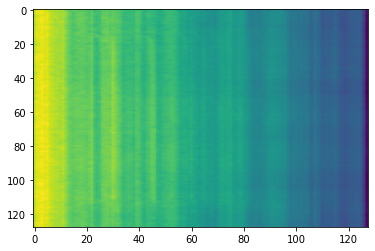

2020-11-05 03:32:18,959 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:14.180973, valid_AUC:0.594754, valid_pAUC:0.509741
100%|██████████| 3452/3452 [00:28<00:00, 122.64it/s]
2020-11-05 03:33:09,700 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.454027, valid_AUC:0.567525, valid_pAUC:0.496664
100%|██████████| 3452/3452 [00:28<00:00, 121.43it/s]
2020-11-05 03:34:00,843 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.126257, valid_AUC:0.569866, valid_pAUC:0.504782
100%|██████████| 3452/3452 [00:28<00:00, 122.62it/s]
2020-11-05 03:34:51,908 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.537839, valid_AUC:0.596231, valid_pAUC:0.513478
100%|██████████| 3452/3452 [00:27<00:00, 123.69it/s]
2020-11-05 03:35:42,526 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.065519, valid_AUC:0.589236, valid_pAUC:0.518104
100%|██████████| 3452/3452 [00:27<00:00, 124.12it/s]
2020-11-05 03:36:33,329 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.864631, v

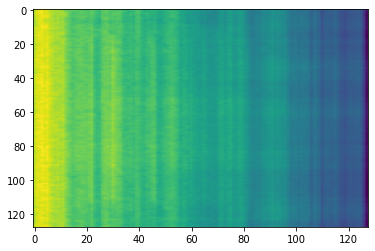

2020-11-05 03:40:47,346 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.988075, valid_AUC:0.581431, valid_pAUC:0.504012
100%|██████████| 3452/3452 [00:27<00:00, 125.06it/s]
2020-11-05 03:41:37,602 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.955971, valid_AUC:0.585992, valid_pAUC:0.504451
100%|██████████| 3452/3452 [00:27<00:00, 124.58it/s]
2020-11-05 03:42:28,325 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.850881, valid_AUC:0.592220, valid_pAUC:0.508744
100%|██████████| 3452/3452 [00:27<00:00, 124.23it/s]
2020-11-05 03:43:18,949 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.698052, valid_AUC:0.583886, valid_pAUC:0.506418
100%|██████████| 3452/3452 [00:27<00:00, 123.39it/s]
2020-11-05 03:44:09,729 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.739220, valid_AUC:0.589553, valid_pAUC:0.510810
100%|██████████| 3452/3452 [00:27<00:00, 125.41it/s]
2020-11-05 03:44:59,905 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.558789, v

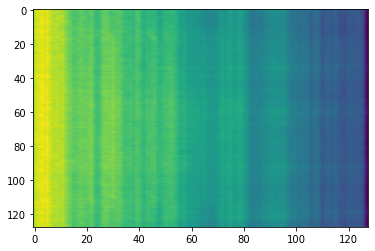

2020-11-05 03:49:12,227 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.279004, valid_AUC:0.585566, valid_pAUC:0.507192
100%|██████████| 3452/3452 [00:27<00:00, 126.09it/s]
2020-11-05 03:50:02,456 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.305066, valid_AUC:0.587008, valid_pAUC:0.507461
100%|██████████| 3452/3452 [00:27<00:00, 126.01it/s]
2020-11-05 03:50:52,970 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.230166, valid_AUC:0.589554, valid_pAUC:0.509540
100%|██████████| 3452/3452 [00:27<00:00, 126.39it/s]
2020-11-05 03:51:42,962 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.064774, valid_AUC:0.577938, valid_pAUC:0.510879
100%|██████████| 3452/3452 [00:27<00:00, 126.09it/s]
2020-11-05 03:52:33,403 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.905028, valid_AUC:0.591113, valid_pAUC:0.510702
100%|██████████| 3452/3452 [00:27<00:00, 126.96it/s]
2020-11-05 03:53:23,406 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.883109, v

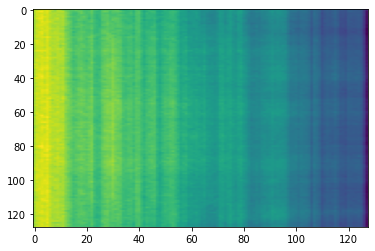

2020-11-05 03:57:34,709 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.722632, valid_AUC:0.585726, valid_pAUC:0.509094
100%|██████████| 3452/3452 [00:27<00:00, 126.18it/s]
2020-11-05 03:58:24,811 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.054991, valid_AUC:0.489899, valid_pAUC:0.496948
100%|██████████| 3452/3452 [00:27<00:00, 126.55it/s]
2020-11-05 03:59:14,995 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.872778, valid_AUC:0.559230, valid_pAUC:0.501363
100%|██████████| 3452/3452 [00:27<00:00, 125.18it/s]
2020-11-05 04:00:05,349 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.756039, valid_AUC:0.579615, valid_pAUC:0.499830
100%|██████████| 3452/3452 [00:27<00:00, 126.21it/s]
2020-11-05 04:00:55,642 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.700415, valid_AUC:0.578229, valid_pAUC:0.501789
100%|██████████| 3452/3452 [00:27<00:00, 126.25it/s]
2020-11-05 04:01:45,834 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.661450, v

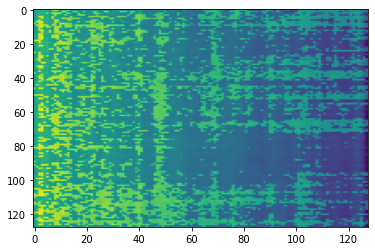

2020-11-05 04:05:56,295 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:15.779269, valid_AUC:0.505618, valid_pAUC:0.500571
100%|██████████| 3452/3452 [00:27<00:00, 126.70it/s]
2020-11-05 04:06:46,766 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:18.922796, valid_AUC:0.558979, valid_pAUC:0.509204
100%|██████████| 3452/3452 [00:27<00:00, 126.87it/s]
2020-11-05 04:07:36,677 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:18.272070, valid_AUC:0.556847, valid_pAUC:0.501150
100%|██████████| 3452/3452 [00:27<00:00, 124.49it/s]
2020-11-05 04:08:27,343 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:18.129314, valid_AUC:0.560374, valid_pAUC:0.510064
100%|██████████| 3452/3452 [00:27<00:00, 125.10it/s]
2020-11-05 04:09:17,604 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:18.108782, valid_AUC:0.560913, valid_pAUC:0.510078
100%|██████████| 3452/3452 [00:27<00:00, 124.40it/s]
2020-11-05 04:10:07,911 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:17.920742, v

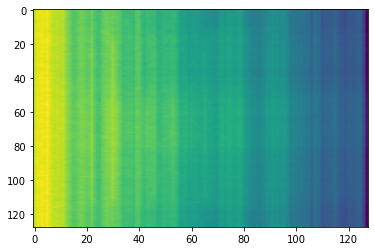

2020-11-05 04:14:20,536 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:16.103119, valid_AUC:0.570535, valid_pAUC:0.507760
100%|██████████| 3452/3452 [00:27<00:00, 124.17it/s]
2020-11-05 04:15:10,879 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:16.056141, valid_AUC:0.569913, valid_pAUC:0.503523
100%|██████████| 3452/3452 [00:28<00:00, 123.12it/s]
2020-11-05 04:16:01,466 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:15.672034, valid_AUC:0.574627, valid_pAUC:0.504814
100%|██████████| 3452/3452 [00:27<00:00, 124.88it/s]
2020-11-05 04:16:52,049 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:15.502759, valid_AUC:0.580855, valid_pAUC:0.507987
100%|██████████| 3452/3452 [00:27<00:00, 124.51it/s]
2020-11-05 04:17:42,478 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:15.337145, valid_AUC:0.577715, valid_pAUC:0.508421
100%|██████████| 3452/3452 [00:27<00:00, 123.48it/s]
2020-11-05 04:18:33,356 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:15.258205, v

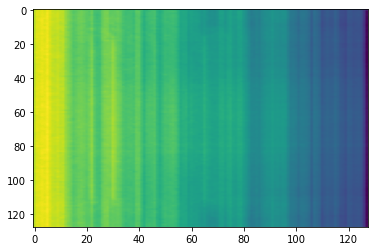

2020-11-05 04:22:46,358 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:14.951508, valid_AUC:0.570161, valid_pAUC:0.508735
100%|██████████| 3452/3452 [00:28<00:00, 122.40it/s]
2020-11-05 04:23:37,221 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:14.873726, valid_AUC:0.582447, valid_pAUC:0.508620
100%|██████████| 3452/3452 [00:28<00:00, 122.43it/s]
2020-11-05 04:24:28,183 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:14.739686, valid_AUC:0.572136, valid_pAUC:0.509323
100%|██████████| 3452/3452 [00:27<00:00, 124.09it/s]
2020-11-05 04:25:18,741 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:14.708768, valid_AUC:0.580222, valid_pAUC:0.506914
100%|██████████| 3452/3452 [00:28<00:00, 122.04it/s]
2020-11-05 04:26:09,717 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:14.660457, valid_AUC:0.575383, valid_pAUC:0.506337
100%|██████████| 3452/3452 [00:27<00:00, 124.29it/s]
2020-11-05 04:27:00,291 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:14.732938, v

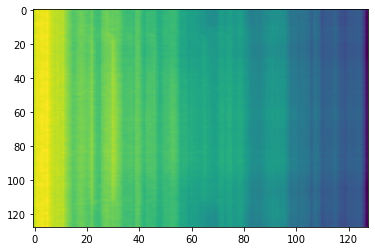

2020-11-05 04:31:12,804 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:14.505997, valid_AUC:0.586484, valid_pAUC:0.511925
100%|██████████| 3452/3452 [00:27<00:00, 124.09it/s]
2020-11-05 04:32:03,369 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:14.503570, valid_AUC:0.574135, valid_pAUC:0.511964
100%|██████████| 3452/3452 [00:27<00:00, 124.81it/s]
2020-11-05 04:32:53,802 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:14.373553, valid_AUC:0.576570, valid_pAUC:0.510801
100%|██████████| 3452/3452 [00:27<00:00, 125.59it/s]
2020-11-05 04:33:43,984 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:14.346056, valid_AUC:0.593699, valid_pAUC:0.512568
100%|██████████| 3452/3452 [00:27<00:00, 125.44it/s]
2020-11-05 04:34:34,375 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:14.148141, valid_AUC:0.587386, valid_pAUC:0.509741
100%|██████████| 3452/3452 [00:27<00:00, 125.66it/s]
2020-11-05 04:35:24,558 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:14.149100, v

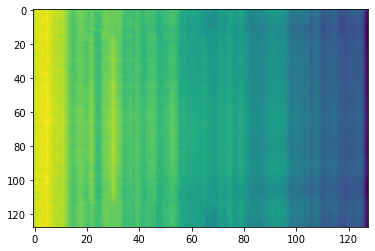

2020-11-05 04:39:36,417 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:14.082073, valid_AUC:0.591876, valid_pAUC:0.510538
2020-11-05 04:39:37,124 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/ToyConveyor_model.pth


elapsed time: 5130.397133827 [sec]


2020-11-05 04:39:37,956 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-05 04:39:37,957 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-05 04:39:37,960 - 00_train.py - INFO - TRAINING
  0%|          | 0/182 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:11<00:00, 76.59it/s]


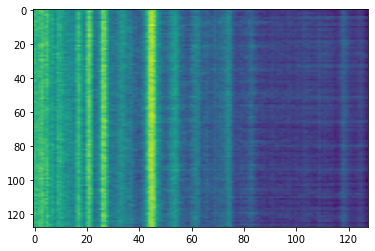

2020-11-05 04:40:56,876 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:68.382079, valid_AUC:0.503571, valid_pAUC:0.505061
100%|██████████| 855/855 [00:06<00:00, 128.74it/s]
2020-11-05 04:41:25,620 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:30.738632, valid_AUC:0.459632, valid_pAUC:0.496096
100%|██████████| 855/855 [00:06<00:00, 122.67it/s]
2020-11-05 04:41:54,631 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:26.570619, valid_AUC:0.456648, valid_pAUC:0.494419
100%|██████████| 855/855 [00:06<00:00, 123.97it/s]
2020-11-05 04:42:23,603 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:25.475972, valid_AUC:0.452242, valid_pAUC:0.500376
100%|██████████| 855/855 [00:06<00:00, 127.99it/s]
2020-11-05 04:42:52,554 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:22.775830, valid_AUC:0.446885, valid_pAUC:0.497802
100%|██████████| 855/855 [00:06<00:00, 125.23it/s]
2020-11-05 04:43:21,306 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:22.044620, valid_AUC:0.45136

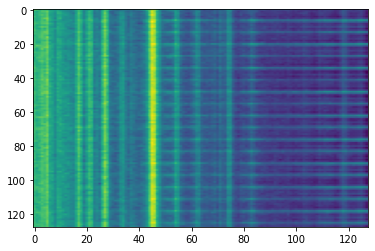

2020-11-05 04:45:16,545 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:17.865038, valid_AUC:0.479632, valid_pAUC:0.500463
100%|██████████| 855/855 [00:06<00:00, 124.12it/s]
2020-11-05 04:45:45,416 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.590468, valid_AUC:0.479324, valid_pAUC:0.502285
100%|██████████| 855/855 [00:06<00:00, 127.45it/s]
2020-11-05 04:46:14,516 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.014927, valid_AUC:0.478077, valid_pAUC:0.497137
100%|██████████| 855/855 [00:06<00:00, 125.80it/s]
2020-11-05 04:46:43,365 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.696052, valid_AUC:0.474780, valid_pAUC:0.499248
100%|██████████| 855/855 [00:06<00:00, 128.98it/s]
2020-11-05 04:47:11,991 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.796736, valid_AUC:0.484588, valid_pAUC:0.506478
100%|██████████| 855/855 [00:06<00:00, 122.69it/s]
2020-11-05 04:47:41,006 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.498015, valid_AUC:0

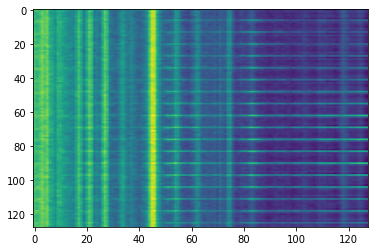

2020-11-05 04:50:06,268 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:13.623188, valid_AUC:0.508418, valid_pAUC:0.502198
100%|██████████| 855/855 [00:06<00:00, 126.17it/s]
2020-11-05 04:50:35,014 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:13.220844, valid_AUC:0.510269, valid_pAUC:0.500752
100%|██████████| 855/855 [00:06<00:00, 128.18it/s]
2020-11-05 04:51:03,631 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.571931, valid_AUC:0.504063, valid_pAUC:0.498843
100%|██████████| 855/855 [00:06<00:00, 123.86it/s]
2020-11-05 04:51:32,256 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.222391, valid_AUC:0.518000, valid_pAUC:0.494968
100%|██████████| 855/855 [00:06<00:00, 128.18it/s]
2020-11-05 04:52:00,958 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.212871, valid_AUC:0.504643, valid_pAUC:0.496964
100%|██████████| 855/855 [00:06<00:00, 127.01it/s]
2020-11-05 04:52:29,880 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.829381, valid_AUC:0

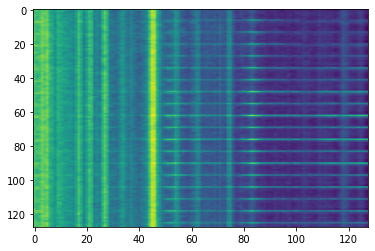

2020-11-05 04:54:54,146 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.323988, valid_AUC:0.511247, valid_pAUC:0.499248
100%|██████████| 855/855 [00:06<00:00, 124.74it/s]
2020-11-05 04:55:23,080 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.179378, valid_AUC:0.509890, valid_pAUC:0.501995
100%|██████████| 855/855 [00:07<00:00, 122.04it/s]
2020-11-05 04:55:51,958 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.006899, valid_AUC:0.502959, valid_pAUC:0.500723
100%|██████████| 855/855 [00:06<00:00, 128.17it/s]
2020-11-05 04:56:20,707 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.904025, valid_AUC:0.516813, valid_pAUC:0.497918
100%|██████████| 855/855 [00:06<00:00, 124.26it/s]
2020-11-05 04:56:49,417 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.946595, valid_AUC:0.504918, valid_pAUC:0.497976
100%|██████████| 855/855 [00:06<00:00, 125.74it/s]
2020-11-05 04:57:18,103 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.051361, valid_AUC:0

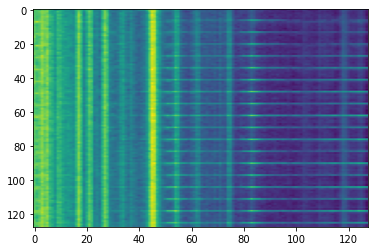

2020-11-05 04:59:42,434 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.584637, valid_AUC:0.510162, valid_pAUC:0.502979
100%|██████████| 855/855 [00:06<00:00, 127.81it/s]
2020-11-05 05:00:11,425 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.497310, valid_AUC:0.517011, valid_pAUC:0.501909
100%|██████████| 855/855 [00:06<00:00, 124.44it/s]
2020-11-05 05:00:40,162 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.620424, valid_AUC:0.517874, valid_pAUC:0.500058
100%|██████████| 855/855 [00:06<00:00, 122.44it/s]
2020-11-05 05:01:09,118 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.835599, valid_AUC:0.511038, valid_pAUC:0.502487
100%|██████████| 855/855 [00:06<00:00, 126.73it/s]
2020-11-05 05:01:37,843 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.971088, valid_AUC:0.505440, valid_pAUC:0.500260
100%|██████████| 855/855 [00:07<00:00, 119.72it/s]
2020-11-05 05:02:07,122 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.784364, valid_AUC:0

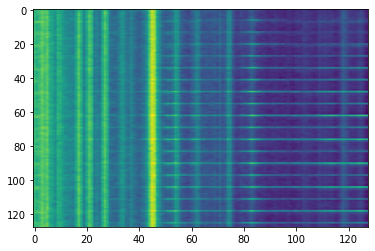

2020-11-05 05:04:30,851 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.512793, valid_AUC:0.520505, valid_pAUC:0.501243
100%|██████████| 855/855 [00:06<00:00, 125.70it/s]
2020-11-05 05:04:59,442 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.283206, valid_AUC:0.510434, valid_pAUC:0.502227
100%|██████████| 855/855 [00:06<00:00, 127.09it/s]
2020-11-05 05:05:27,916 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.147823, valid_AUC:0.508659, valid_pAUC:0.504309
100%|██████████| 855/855 [00:06<00:00, 124.70it/s]
2020-11-05 05:05:56,700 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.099501, valid_AUC:0.520033, valid_pAUC:0.501446
100%|██████████| 855/855 [00:06<00:00, 122.54it/s]
2020-11-05 05:06:25,844 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.122764, valid_AUC:0.505874, valid_pAUC:0.496385
100%|██████████| 855/855 [00:06<00:00, 127.82it/s]
2020-11-05 05:06:54,597 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.482853, valid_AUC:0

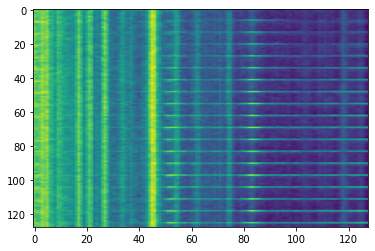

2020-11-05 05:09:18,798 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.626909, valid_AUC:0.515467, valid_pAUC:0.504829
100%|██████████| 855/855 [00:06<00:00, 127.67it/s]
2020-11-05 05:09:47,546 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.494077, valid_AUC:0.513709, valid_pAUC:0.502400
100%|██████████| 855/855 [00:06<00:00, 124.82it/s]
2020-11-05 05:10:16,569 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.299224, valid_AUC:0.510802, valid_pAUC:0.502603
100%|██████████| 855/855 [00:06<00:00, 128.04it/s]
2020-11-05 05:10:45,238 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.260909, valid_AUC:0.511451, valid_pAUC:0.495402
100%|██████████| 855/855 [00:06<00:00, 127.43it/s]
2020-11-05 05:11:14,019 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.172168, valid_AUC:0.507335, valid_pAUC:0.492655
100%|██████████| 855/855 [00:06<00:00, 124.28it/s]
2020-11-05 05:11:42,790 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.127022, valid_AUC:0

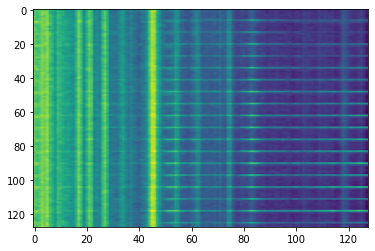

2020-11-05 05:14:07,532 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.082222, valid_AUC:0.511170, valid_pAUC:0.489127
100%|██████████| 855/855 [00:06<00:00, 126.52it/s]
2020-11-05 05:14:36,388 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.869014, valid_AUC:0.512286, valid_pAUC:0.501938
100%|██████████| 855/855 [00:06<00:00, 127.68it/s]
2020-11-05 05:15:04,921 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.874246, valid_AUC:0.514451, valid_pAUC:0.507143
100%|██████████| 855/855 [00:06<00:00, 123.15it/s]
2020-11-05 05:15:34,058 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.895429, valid_AUC:0.513195, valid_pAUC:0.503297
100%|██████████| 855/855 [00:06<00:00, 126.83it/s]
2020-11-05 05:16:02,944 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.850987, valid_AUC:0.518060, valid_pAUC:0.502979
100%|██████████| 855/855 [00:06<00:00, 127.72it/s]
2020-11-05 05:16:31,641 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.078006, valid_AUC:0

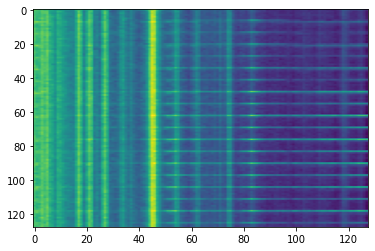

2020-11-05 05:18:55,792 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.645896, valid_AUC:0.506473, valid_pAUC:0.498959
100%|██████████| 855/855 [00:06<00:00, 123.41it/s]
2020-11-05 05:19:24,650 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.195863, valid_AUC:0.509489, valid_pAUC:0.505870
100%|██████████| 855/855 [00:06<00:00, 123.45it/s]
2020-11-05 05:19:53,607 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.072181, valid_AUC:0.508302, valid_pAUC:0.503123
100%|██████████| 855/855 [00:06<00:00, 127.97it/s]
2020-11-05 05:20:22,451 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.993089, valid_AUC:0.511385, valid_pAUC:0.504251
100%|██████████| 855/855 [00:06<00:00, 124.81it/s]
2020-11-05 05:20:51,105 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.828869, valid_AUC:0.517264, valid_pAUC:0.498930
100%|██████████| 855/855 [00:06<00:00, 127.74it/s]
2020-11-05 05:21:19,550 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.783027, valid_AUC:0

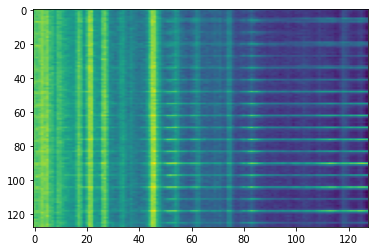

2020-11-05 05:23:43,774 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.770975, valid_AUC:0.501352, valid_pAUC:0.500000
100%|██████████| 855/855 [00:06<00:00, 127.71it/s]
2020-11-05 05:24:12,818 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.024474, valid_AUC:0.515313, valid_pAUC:0.501706
100%|██████████| 855/855 [00:06<00:00, 124.21it/s]
2020-11-05 05:24:41,740 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.828395, valid_AUC:0.506989, valid_pAUC:0.504598
100%|██████████| 855/855 [00:06<00:00, 125.50it/s]
2020-11-05 05:25:10,695 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.671960, valid_AUC:0.516330, valid_pAUC:0.504164
100%|██████████| 855/855 [00:06<00:00, 128.11it/s]
2020-11-05 05:25:39,332 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.684780, valid_AUC:0.521121, valid_pAUC:0.506246
100%|██████████| 855/855 [00:07<00:00, 120.15it/s]
2020-11-05 05:26:08,508 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.679413, valid_AUC:0

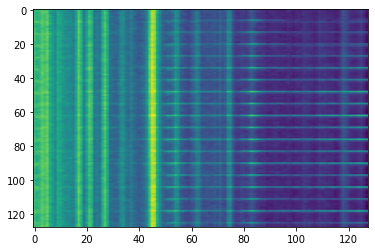

2020-11-05 05:28:32,111 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.865074, valid_AUC:0.519214, valid_pAUC:0.503210
2020-11-05 05:28:32,882 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AE_simple/models/valve_model.pth


elapsed time: 2934.928731918 [sec]


In [11]:
for machine_type in machine_types:
    #if (machine_type == machine_types[0]) or (machine_type == machine_types[1]):
    #    continue
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)